## Alberta Electricity Load Pattern Analysis
##### Joshua Quartey
##### Lecture L01

#### SECTION A: INTRODUCTION 

Alberta’s electricity grid experiences load swings influenced by weather, seasonal demand, and generation mix. In this project, unsupervised learning (PCA and k-means clustering) is applied to reduce 24-hour demand curves into lower dimensional representations to identify distinct patterns. Supervised models (decision tree and logistic regression) are also used to predict high-demand days using only early-morning signals. By uncovering principal load axes and extracting simple decision rules, operators gain timely, data-driven insights for reserve scheduling and demand-response, enhancing grid reliability and cost efficiency.


##### Main Objective
Analyze Alberta’s hourly electricity demand to (a) reduce high-dimensional load‐time series into a few key patterns for visualization, (b) cluster days or weeks into distinct load‐profile categories , and (c) build a classifier that predicts whether a given day will be “high‐demand” (e.g., top decile) based on early‐morning usage.

#### SECTION B: OBJECTIVES & RESEARCH QUESTIONS

##### Analysis Questions
Q01: When you treat each day’s 24‐hour load curve as a 24‐dimensional vector, what principal components (via PCA) explain most of the variance? 

Objective: Identify and quantify the primary axes of variation in Alberta’s daily electricity demand by determining which principal components, derived from PCA on 24‐hour load vectors, capture the majority of variance.

Q02: Based on the top 2–3 principal components, can k‐means identify coherent “day‐type” clusters (eg. “cold‐winter‐peak,” “shoulder‐two‐peak,” “summer‐valley”)?

Objective: Group days into distinct operational lusters by applying k‐means clustering to the top two or three PCA components—thereby revealing coherent “day‐type” clusters.

Q03: Using early‐morning (eg. midnight to 8 AM) load values, and day‐of‐week, how well can a decision tree or logistic regression model predict whether a day’s peak load (eg. max hourly load) will fall into the top 10% of historical peaks?

Objective: Build and evaluate decision‐tree and logistic regression classifiers that use early‐morning load values (midnight–8 AM) and day‐of‐week information to predict whether a day’s peak load will rank in the top 10 percent of historical daily peaks.


Q04: Which features most strongly drive “high‐demand” days? What simple decision rules  could grid operators use for early‐warning and demand‐response planning?

Objective: Determine which predictor variables (raw loads and fuel‐utilization metrics) most strongly influence high‐demand days and extract concise “if–then” decision rules that grid operators can deploy for early warning and demand‐response planning.

#### SECTION C: DATA SOURCING & JUSTIFICATION 

The primary dataset for this analysis is from the Alberta Electric System Operator’s (AESO) publicly available [Hourly Metered Volumes and Pool Price and AIL Data (2010–2023)](https://www.aeso.ca/market/market-and-system-reporting/data-requests/hourly-metered-volumes-and-pool-price-and-ail-data-2010-to-2023). It provides timestamped, hourly metered volumes for each generating asset, actual pool price, actual ancillary‐service payments, and inter‐provincial import/export flows. The data in this dataset provides daily 24‐hour load curves and allows extracting early‐morning demand signals—key inputs for clustering patterns and predicting high‐demand days.

The [AESO Current Supply & Demand Asset List](https://www.aeso.ca/market/market-and-system-reporting/data-requests/current-supply-demand-asset-list), which includes each asset’s short name, fuel type (gas, coal, hydro, wind, solar, etc.), sub‐fuel type, and maximum capability was also integrated. It was merged based on the common asset short names to compute fuel‐type aggregated generation and per‐asset capacity utilization. This was used in dimensionality‐reduction (PCA) and clustering.

#### SECTION D: DATA CLEANING & PREPARATION

Cleaning of the dataset involved the following stages:
##### Loading & Cleaning AESO Hourly Data
- The "Date_Begin_Local" column was renamed to "timestamp" and set as the DatetimeIndex.

- All remaining columns (node volumes, prices, import/exports) were converted to numeric and fill any missing values.

- A new column "total_system_load_MW" was calculated by summing all node volume columns.

##### Loading and Processing Asset Metadata
- The metadata was filtered to only include assets present in the AESO node columns, and report any node columns missing metadata.

- Lookup dictionaries were used to map each node (e.g., "AFG1") to its fuel type (eg. "Natural Gas") and maximum capacity in MW.

- The Asset‐Specific Utilization was computed for each asset/node( asset_utilization = current_generation / max_capability). eg. AFG1_utilization

<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="data cleaning fuel utilization generation columns.jpg">
	<figcaption><strong>Figure:</strong> dataset with new calculated columns.</figcaption>
</figure>

- Assets were grouped by their fuel_type (eg. all "Natural Gas" assets) and for each fuel group, the sum of generation across all assets of that fuel type and total installed capacity for that fuel type were computed.

- Missing values were filled in using forward/backward fill


The final cleaned dataframe contained:
- The original node/asset volume columns and price columns, total_system_load_MW column, asset‐specific utilization columns( eg. AFG1_utilization, AKG1_utilization, etc.),and fuel‐type aggregated columns (eg. gen_Natural Gas, gen_Coal, util_Natural Gas, etc).

<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="data cleaning fcalculated columns.jpg">
	<figcaption><strong>Figure:</strong> dataset after cleaning.</figcaption>
</figure>

These steps allow that dimensionality‐reduction, clustering, and classification steps be done on both raw node‐level data and aggregated, interpretable features based on fuel group or utilization.

#### SECTION E: ANALYTICAL METHODS & IMPLEMENTATION

##### Methodology Overview
This machine learning project uses dimensionality reduction, clustering and classification techniques to analyze Alberta’s electricity demand patterns and predict high‐demand days. To begin, we construct two feature sets: 
- raw hourly load values (`load_00`–`load_08`) and
- fuel‐type utilization metrics (average and maximum utilization for gas, coal, hydro, solar, wind)

Next, dimensionality‐reduction(Principal Component Analysis) is applied to each feature set to reduce high‐dimensional daily load curves into two or three key components. 

Next, clustering(k‐means) is performed on the reduced‐dimension representations to group days into meaningful clusters. 

Finally, the raw‐load and fuel‐utilization features are combined to train two classification models, Decision Trees and Logistic Regression, to predict whether a given day will be a top‐decile high-demand day using only early‐morning signals (midnight–08:00).

##### Dimensionality Reduction & Clustering
To begin, each feature set is standardized to zero mean and unit variance. For the raw‐loads set (`load_00` to `load_23`), PCA is chosen because it identifies the orthogonal directions of greatest variance in 24‐hour demand curves and easily explains the cumulative variance captured by successive components.
For clustering, k‐means is used to partition days into k groups and these clusters are evaluated using silhouette scores which measure cluster cohesion(close to 1 indicates appropriate clustering, near 0 indicates the data point is close to the decision boundary between clusters, negative values suggest the data point might be misassigned) The same procedure is repeated on the fuel‐utilization features (mean and max utilization per fuel type) to compare which set yields more coherent clusters.

<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="method pca.jpg">
	<figcaption><strong>Figure:</strong> Code snippet: performing PCA.</figcaption>
</figure>

##### Classification 
In wholesale electricity markets like Alberta’s, system operators and market participants rely on day‐ahead or same‐day signals to schedule generation, procure reserves, and coordinate demand‐response programs.  
A classifier based on early‐morning load features can help system operators preemptively mobilize reserves or enact demand‐response incentives on anticipated high‐demand days.

<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="method class 1.jpg">
	<figcaption><strong>Figure:</strong> Code snippet: Creating feature set for classification.</figcaption>
</figure>

<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="method class 2.jpg">
	<figcaption><strong>Figure:</strong> Code snippet: Creating feature set for classification.</figcaption>
</figure>

Using the first eight hours of a day’s demand to predict whether that day will enter the top decile of the highest loads ever recorded provides a practical early‐warning signal. Choosing the 10 % threshold balances focusing on truly extreme days with having enough representative training examples. Using an interpretable rule set (from a decision tree) and a probability score (from logistic regression) helps system operators to make informed, time‐sensitive decisions improving reliability, while mitigating price spikes.

A day is labeled as high-demand if its maximum hourly load lies in the top 10 % historically. The combined feature matrix includes raw loads `load_00`–`load_08` plus early‐morning fuel‐utilization (`util_GAS_avg_0_8AM`, `util_HYDRO_avg_0_8AM`, etc.) and a one‐hot encoding of `day_of_week`. Each model is trained on the 2010–2021 data, validated on 2022, and tested on 2023 using a time‐series split rather than random sampling.

##### Evaluation Metrics & Visualizations
For PCA, the metrics used for evaluation were the explained‐variance ratios by component. 2-D scatterplots in PC space(PC1 vs. PC2) color-coded by cluster label were also used

For Clustering, silhouette scores were primarily used to select the optimal number of clusters. Cluster‐average 24-hour curves were also used to characterize each cluster’s typical load‐shape. 

For Classification, accuracy, precision, recall, F1-score, and confusion matrices are used to evaluate performance on validation and test sets. ROC curves and AUC were also calculated for each model. The analysis will also include a decision‐tree diagram .

#### SECTION F: INSIGHTS AND DISCUSSION

##### Dimensionality Reduction and Clustering
Which set of features produced better clusters/were better at grouping days based on demand, raw loads or utilization by fuel type?

When clustering using the fuel‐utilization PCA (using eight components) the silhouette score did not exceed $0.2565 (at k=6)$, with negative silhouette values appearing in at least one cluster for every $k$ value. The raw‐loads PCA clustering (peak silhouette ≈ 0.46) seems to be stronger and more distinct than the fuel‐utilization PCA clustering (peak silhouette ≈ 0.26).

<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="fuel util silhouette scores.jpg">
	<figcaption><strong>Figure:</strong> fuel utilization feature set silhouette scores.</figcaption>
</figure>

<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="fuel util clusters.png">
	<figcaption><strong>Figure:</strong> fuel utilization clusters.</figcaption>
</figure>

<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="fuel util pca explained var.jpg">
	<figcaption><strong>Figure:</strong> fuel utilization pca explained variance by components.</figcaption>
</figure>


<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="2fuel util silhouette plots.png">
	<figcaption><strong>Figure:</strong> fuel utilization feature set silhouette plot k = 2 .</figcaption>
</figure>

<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="3fuel util silhouette plots.png">
	<figcaption><strong>Figure:</strong> fuel utilization feature set silhouette plot k = 3.</figcaption>
</figure>

<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="4fuel util silhouette plots.png">
	<figcaption><strong>Figure:</strong> fuel utilization feature set silhouette plot k = 4.</figcaption>
</figure>

When clustering days using the first seven principal components of the raw‐loads PCA, using tow clusters yielded the highest average silhouette score of $0.4636 (k=2)$. As $k$ increases, silhouette gradually decreased—to $0.3999 (k=3)$, $0.3503 (k=4)$, down to $0.2477 (k=7)$. Although there were slight negative silhouette scores in one small cluster as $k$ increased, overall the raw‐load feature set produced relatively well‐separated clusters.

The raw‐loads feature set seems to clusters better because the first three raw‐load PCs capture 96.83 % of variance. Using seven components increases that to 99.16 % cumulative variance, meaning the 7D representation closely approximates the full 24‐hour load curves. 

For the fuel‐utilization features (mean and max for each fuel type), it takes seven components to explain 91.87 %, and eight to explain 97.37 %. This indicates that the fuel‐utilization PCA is more spread‐out, which might be because aggregating by fuel type discards some hour‐by‐hour nuances.

While raw‐loads PCA produces more cohesive clusters (higher silhouette), the fuel‐utilization PCA clusters can offer clearer, operationally meaningful groupings. For example, PC_FUEL1 loads heavily on `util_SOLAR_max`, `util_GAS_max`, `util_OTHER_max`, and `util_GAS_mean`, indicating a “solar/gas intensity” axis, whereas PC_FUEL2 is driven by `util_HYDRO_mean/max`, capturing “hydro abundance.” A cluster might represent “coal‐heavy winter days” versus “gas‐peak summer days.”

<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="2loadings only silhouette plots.png">
	<figcaption><strong>Figure:</strong> raw loads silhouette plots k = 2.</figcaption>
</figure>

<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="3loadings only silhouette plots.png">
	<figcaption><strong>Figure:</strong> raw loads silhouette plots k = 3.</figcaption>
</figure>

<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="loads raw clustering.jpg">
	<figcaption><strong>Figure:</strong> raw loads feature set clustering.</figcaption>
</figure>
![](<attachment:loads raw clustering.jpg>)
<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="load curves by cluster.png">
	<figcaption><strong>Figure:</strong> 24 hour demand curves by cluster using raw loads feature set.</figcaption>
</figure>

###### Cluster 0 (Blue Line: Highest Curve)
The high-demand days in cluster 0 could be  most likely winter weekdays when space‐heating demand is strongest. The elevated overnight baseline suggests cold overnight temperatures, and the large evening taper could be indicative of residential and commercial usage after‐work hours.

###### Cluster 2 (Green Line: Middle Curve)
This cluster could represent “mid‐range” or days (eg. spring or autumn weekdays) when temperatures are likely moderate, so overnight loads are lower than in winter, but the evening peak still appears in response to normal work‐day schedules and moderate heating or cooling needs.

###### Cluster 1 (Orange Line: Lowest Curve)
These “low‐demand” days are likely weekends or major holidays or mild summer days. With many businesses closed and lower residential heating/cooling, both the daytime plateau ($\approx 6 200 MW$) and evening ramp ($\approx 6 500 MW$) are noticeably flattened.

All three clusters share the familiar 24-hour pattern of ramping during‐the‐morning, then relatively plateauing at midday to peak late‐afternoon followed by a taper off overnight.

In practice, these clusters could be labeled “Winter‐Peak,” “Mild‐Weekday,” and “Weekend/Low” which helps system planners anticipate reserve needs, price signals, or demand‐response targets for each day type.

##### Classification
<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="logistic regression validation.jpg">
	<figcaption><strong>Figure:</strong> Logistic regression performance on validation set.</figcaption>
</figure>

<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="Decision tree validation.jpg">
	<figcaption><strong>Figure:</strong> Decision tree performance on validation set.</figcaption>
</figure>

<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="logistic regression test.jpg">
	<figcaption><strong>Figure:</strong> Logistic regression performance on test set.</figcaption>
</figure>

<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="Decision tree test.jpg">
	<figcaption><strong>Figure:</strong> Decision tree performance on test set.</figcaption>
</figure>

###### Overall Accuracy
On the validation set, the tree's accuracy was 95% and 90% for the logistic regression model. On the test set, the tree's accuracy was 85% and was 82% for the logistic regression model.

The decision tree outperforms the logistic regression model in both cases in terms of accuracy.
	
Ability to Detect High-demand Days (Recall on Class 1):
The decision tree detects 79% of high-demand days in the validation set and 63% in the test set.The logistic regression model detects only 26% (validation) and 29% (test). Similarly, the tree outperforms at flagging actual high-demand days

###### Precision
The decision tree achieves 74% precision on the validation set and 70% on the test set. The logistic regression model achieves 59% in validation and 82% on the test set.

It appears that the Logistic Regression model is a little more conservative when predicting high-demand days(low recall), but it is often correct (82% on test).

###### ROC AUC
The decision tree maintains a substantially higher AUC on both splits(0.948 for validation and 0.848 for test), indicating that its probability scores discriminate high-demand vs non-high-demand days more cleanly.

###### Interpretability
Because the tree is not too complex, it’s splits are very easy to interpret. An example decision rule is: “If 8 AM demand > 7942 MW, predict high-demand.” 

The logistic regression model coefficients indicate early‐morning gas utilization and wind utilization are strong predictors (3.07 and 2.63), meaning that a high fraction of gas plants running overnight drastically raises the probability of a spike. The raw‐load coefficients are very small (about 1.00) and day‐of‐week effects are mostly negligible. The logistic regression depends more strongly on fuel‐type utilization predictors.

<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="Decision tree full.png">
	<figcaption><strong>Figure:</strong> decision tree visualization.</figcaption>
</figure>

<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="decision tree text representation.jpg">
	<figcaption><strong>Figure:</strong> decision tree rules.</figcaption>
</figure>

<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="logistic regression top odds.jpg">
	<figcaption><strong>Figure:</strong> logistic regression coefficients.</figcaption>
</figure>

The fitted decision tree shows that 8 AM demand (load\_08) is the strongest early‐morning indicator of a high‐demand day. Specifically:

* Rule 1: If 8 AM load > 8182 MW, the model always classifies the day as high‐demand.

* Rule 2: If 7942 MW < 8 AM load ≤ 8182 MW , the model still predicts high‐demand regardless of the 1 AM load.

* Rule 3: If 8 AM load ≤ 7942 MW but midnight load > 6873.94 MW, we then check 1 AM load. If 1 AM load > 7279.48 MW, the day is classified as high‐demand; otherwise, it is non‐high‐demand.

* Rule 4: If 8 AM load ≤ 7942 MW and midnight load ≤ 6873.94 MW, the model immediately predicts non‐high‐demand (even if 8 AM load is slightly above 7279.93 MW).

These rules yield these actionable thresholds:

1. load_08 ≈ 8183 MW is a definite indicator of a high-demand day, any 8 AM value above this means a high‐demand day.

3. For days with 8 AM load ≤ 7942 MW, a late‐night indicator (“midnight load > 6873.94 MW” and “1 AM load > 7279.48 MW”) serves as a secondary check for high demand.

These decision rules allow a grid operator to issue an early‐morning high‐demand alert whenever 8 AM load exceeds 7942 MW, or when midnight/1 AM loads cross their respective thresholds.


##### Model Selection
<figure style="text-align: center;">
	<img title="a title" alt="Alt text" src="ROC curves comparison.png">
	<figcaption><strong>Figure:</strong> ROC cuves comparison for decision tree and logistic regression model on test set.</figcaption>
</figure>

The decision‐tree is the superior model as it has a high recall on class 1 and so is able to detect high-demand days better. Its recall is roughly three times that of the logistic regression model, ensuring far fewer missed high-demand day alerts.

The logistic regression can be less reliable because it is more conservative and so avoids false positives (higher precision) but at the cost of missing most high-demand days. It could be more preferred if false alarms cannot be tolerated. Missing a true high‐demand day can have also have severe reliability and cost consequences. In most grid‐operation scenarios, maximizing recall on impending high‐demand days is more important than minimizing false alarms as a missed spike can lead to load shedding or extremely high spot prices. 

The decision‐tree could be deployed as the primary detector and then layered on top of that could be the logistic regression model's high‐precision as a secondary check or to set different alert levels (monitor vs. act).
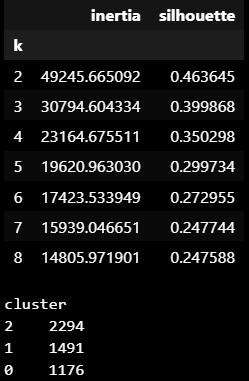